# Imports

In [1]:
import warnings
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import lasso_path
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV


# Ignora todos los FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Funciones

In [2]:
def plot_scatter_variables(df, target, variables=None):
    if variables is None:
        variables = [col for col in df.columns if col != target]

    num_vars = len(variables)
    cols = 3  # Número de columnas en la cuadrícula de subplots
    rows = (num_vars // cols) + (num_vars % cols > 0)  # Ajustar número de filas
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Convertimos en un array 1D para indexar fácilmente

    for i, var in enumerate(variables):
        sns.scatterplot(x=df[var], y=df[target], ax=axes[i], alpha=0.6)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'{var} vs {target}')
    
    # Ocultar ejes vacíos si sobran
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
def plot_correlation_heatmap(df, method = None):
    if method is None:
        # Calculamos la matriz de correlación entre las variables numéricas
        corr_matrix = df.corr()
    else:
        corr_matrix = df.corr(method = method)
    # Dibujamos el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Correlación entre las Variables')
    plt.show()
    
def print_regression_report(y_true, y_pred):
    #evaluate our model's performance using mean squared error
    mse=mean_squared_error(y_true, y_pred)
    
    #evaluate our model's performance using mean absolute error
    mae=mean_absolute_error(y_true, y_pred)
    
    #evaluate our model's performance using r2_score
    R2_score=r2_score(y_true, y_pred)
    
    print("Mean Squared Error :",mse)
    print("mean Absolute Error :",mae)
    print("R2 Score :",R2_score)
    
def plot_correlation_heatmap_doble(df, method, ax):
    """
    Dibuja un heatmap de correlación en el eje ax dado.
    """
    corr_matrix = df.corr(method=method)
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar=True, ax=ax)
    ax.set_title(f'Correlación ({method.capitalize()})')
    
def plot_comparison_original_transformed(df, target, pairs, bins):
    """
    Muestra para cada par (var_orig, var_trans):
       - Histograma var_orig (col izq, fila 1)
       - Histograma var_trans (col dcha, fila 1)
       - Scatter var_orig vs. target (col izq, fila 2)
       - Scatter var_trans vs. target (col dcha, fila 2)
    """
    for (var_orig, var_trans) in pairs:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        
        # --- Fila 1, Col 1: Histograma ORIGINAL ---
        sns.histplot(df[var_orig], kde=False, ax=axes[0, 0], bins=bins)
        axes[0, 0].set_title(f'Histograma de {var_orig} (Original)')
        axes[0, 0].set_xlabel(var_orig)
        axes[0, 0].set_ylabel('Frecuencia')
        
        # --- Fila 1, Col 2: Histograma TRANSFORMADA ---
        sns.histplot(df[var_trans], kde=False, ax=axes[0, 1], bins=bins)
        axes[0, 1].set_title(f'Histograma de {var_trans} (Transformada)')
        axes[0, 1].set_xlabel(var_trans)
        axes[0, 1].set_ylabel('Frecuencia')
        
        # --- Fila 2, Col 1: Scatter ORIGINAL vs. target ---
        sns.scatterplot(x=df[var_orig], y=df[target], ax=axes[1, 0], alpha=0.6)
        axes[1, 0].set_title(f'{var_orig} vs. {target} (Original)')
        axes[1, 0].set_xlabel(var_orig)
        axes[1, 0].set_ylabel(target)
        
        # --- Fila 2, Col 2: Scatter TRANSFORMADA vs. target ---
        sns.scatterplot(x=df[var_trans], y=df[target], ax=axes[1, 1], alpha=0.6)
        axes[1, 1].set_title(f'{var_trans} vs. {target} (Transformada)')
        axes[1, 1].set_xlabel(var_trans)
        axes[1, 1].set_ylabel(target)
        
        plt.tight_layout()
        plt.show()
        
def plot_correlation_heatmaps_side_by_side(df, columns, methods=('spearman', 'pearson')):
    """
    Dibuja, en una sola figura con dos subplots (lado a lado),
    los heatmaps de correlación para el conjunto de columnas 'columns'
    usando los dos métodos especificados en 'methods'.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 fila, 2 columnas

    for i, m in enumerate(methods):
        corr_matrix = df[columns].corr(method=m)
        sns.heatmap(
            corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            cbar=True,
            ax=axes[i]
        )
        axes[i].set_title(f'Correlación ({m.capitalize()})', fontsize=14)

    plt.tight_layout()
    plt.show()
    
def print_regression_report_with_rmse(y_true, y_pred, dataset_name="Dataset"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n=== Evaluación en {dataset_name} ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
def mdi_regressor(X, y):
    rft = RandomForestRegressor(random_state=42)
    rft.fit(X, y)
    mdi_importance = rft.feature_importances_

    feature_names = X.columns
    indices = np.argsort(mdi_importance)[::-1]  # Ordenar por importancia

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mdi_importance)), mdi_importance[indices], align="center", color='skyblue')
    plt.xticks(range(len(mdi_importance)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDI Importance")
    plt.title("Feature Importance (MDI) - Random Forest Regressor")
    plt.tight_layout()
    plt.show()
    
def mda_regressor(X, y):
    feature_names = X.columns
    rft = RandomForestRegressor(random_state=42)
    rft.fit(X, y)
    
    perm_importance = permutation_importance(rft, X, y, scoring="r2", n_repeats=10, random_state=42)
    importance_means = perm_importance.importances_mean
    importance_stds = perm_importance.importances_std
    indices = np.argsort(importance_means)[::-1]  # Ordenar por importancia
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance_means)), importance_means[indices], yerr=importance_stds[indices], align="center", color="lightcoral", capsize=5)
    plt.xticks(range(len(importance_means)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDA Importance")
    plt.title("Feature Importance (MDA) - Random Forest Regressor")
    plt.tight_layout()
    plt.show()
    
    

# Housing - Regression


## Variables

| **Variable** | **Descripción** |
|-------------|---------------|
| **CRIM** | Tasa de criminalidad per cápita por ciudad |
| **ZN** | Proporción de terreno residencial para lotes mayores a 25,000 pies cuadrados |
| **INDUS** | Proporción de acres comerciales no minoristas por ciudad |
| **CHAS** | Variable dummy del río Charles (1 si limita con el río; 0 en caso contrario) |
| **NOX** | Concentración de óxidos nítricos (partes por 10 millones) |
| **RM** | Número promedio de habitaciones por vivienda |
| **AGE** | Proporción de unidades ocupadas por propietarios construidas antes de 1940 |
| **DIS** | Distancia ponderada a cinco centros de empleo de Boston |
| **RAD** | Índice de accesibilidad a carreteras radiales |
| **TAX** | Tasa de impuestos sobre la propiedad por cada $10,000 |
| **PTRATIO** | Relación alumnos-profesor por ciudad |
| **B** | 1000(Bk - 0.63)^2 donde Bk es la proporción de población negra por ciudad |
| **LSTAT** | Porcentaje de población de bajo estatus |
| **MEDV** | Valor medio de viviendas ocupadas por sus propietarios (en miles de dólares) |


## Cargamos los datos

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Usar el delimitador adecuado con 'sep'
housing_df = pd.read_csv('housing.csv', names=column_names, sep='\s+')

## EDA

In [11]:
housing_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
housing_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


### Histogramas

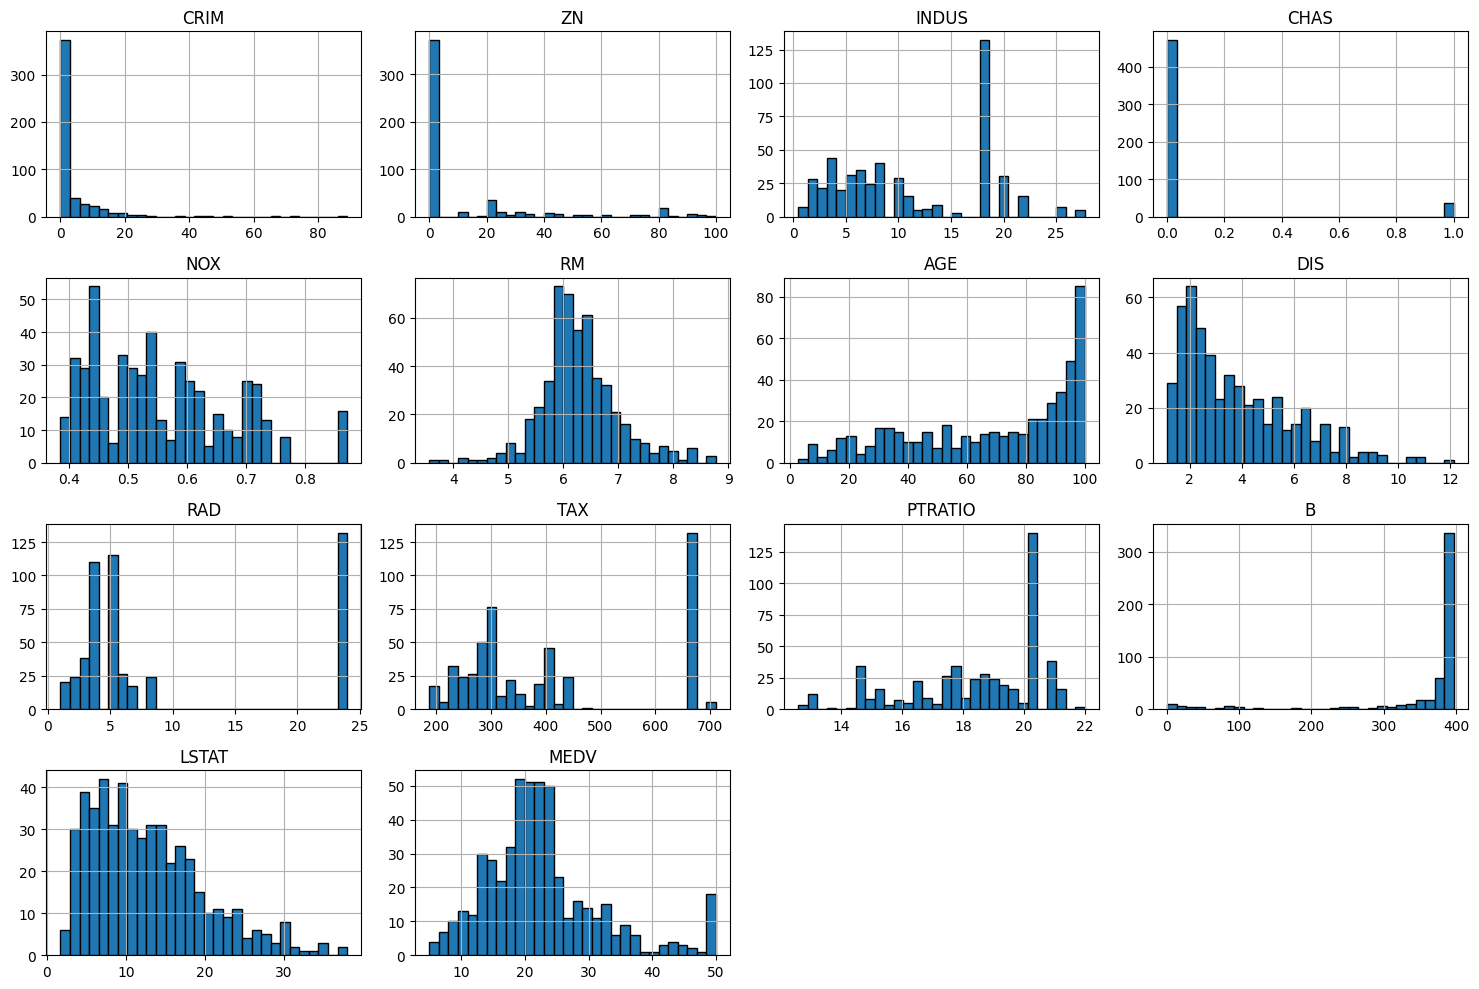

In [ ]:
# Configuración del tamaño de las gráficas
housing_df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

1. CRIM (Tasa de criminalidad per cápita)
- Distribución: Altamente sesgada a la derecha.
- Interpretación: La mayoría de las zonas tienen tasas de criminalidad muy bajas, pero hay algunas con tasas significativamente más altas (outliers).
- Acción: Considera aplicar una transformación logarítmica para reducir el sesgo.

2. ZN (Proporción de terrenos residenciales para lotes grandes)
- Distribución: Sesgo a la derecha con muchos valores en 0.
- Interpretación: Muchas zonas no tienen terrenos residenciales grandes, y unas pocas tienen proporciones altas.
- Acción: Este tipo de variable puede comportarse como categórica o binaria en algunos modelos.

3. INDUS (Proporción de terrenos no comerciales)
- Distribución: Bimodal, con picos alrededor de 6 y 18.
- Interpretación: Algunas áreas tienen baja industrialización mientras que otras son altamente industriales.
- Acción: Revisa la correlación con MEDV, ya que zonas más industriales podrían tener valores de viviendas más bajos.

4. CHAS (Variable dummy del Río Charles)
- Distribución: Altamente desequilibrada, la mayoría es 0 (no colinda con el río).
- Interpretación: Muy pocas propiedades están cerca del río.
- Acción: Puede tener un impacto significativo en el precio de las viviendas debido a su naturaleza binaria.

5. NOX (Concentración de óxidos nítricos)
- Distribución: Sesgada hacia la izquierda, pero relativamente dispersa.
- Interpretación: La mayoría de las áreas tienen concentraciones bajas, aunque hay valores altos que podrían afectar negativamente el valor de las viviendas.
- Acción: Considera la relación con INDUS y CRIM.

6. RM (Número promedio de habitaciones por vivienda)
- Distribución: Aproximadamente normal.
- Interpretación: La mayoría de las viviendas tienen entre 5 y 7 habitaciones. Esto es una buena señal para la regresión lineal.
- Acción: Altamente correlacionada con MEDV, generalmente más habitaciones = mayor precio.

7. AGE (Proporción de viviendas construidas antes de 1940)
- Distribución: Sesgada a la izquierda.
- Interpretación: Muchas viviendas son antiguas (más del 80%).
- Acción: Podría relacionarse negativamente con MEDV, dependiendo del estado de las viviendas.

8. DIS (Distancia a los centros de empleo)
- Distribución: Sesgada a la derecha.
- Interpretación: La mayoría de las viviendas están cerca de los centros de empleo, pero algunas están mucho más alejadas.
- Acción: Puede tener una relación inversa con MEDV, donde viviendas más cercanas a centros urbanos son más costosas.

9. RAD (Accesibilidad a autopistas radiales)
- Distribución: Discreta y altamente sesgada.
- Interpretación: Algunos valores específicos son muy comunes, lo que indica que ciertos niveles de accesibilidad son más frecuentes.
- Acción: Variable categórica en esencia, podría transformarse para modelos.

10. TAX (Tasa de impuesto a la propiedad)
- Distribución: Multimodal, con un pico significativo alrededor de 660.
- Interpretación: Las tasas de impuestos varían bastante entre las zonas.
- Acción: Revisar la correlación con RAD y INDUS.

11. PTRATIO (Proporción alumno-profesor por zona)
- Distribución: Discreta con acumulación en ciertos valores.
- Interpretación: Muchas zonas comparten las mismas proporciones de alumnos por maestro.
- Acción: Podría tener una relación inversa con MEDV, donde menores ratios indican mejores escuelas y valores de vivienda más altos.

12. B (Proporción de personas de raza negra por zona, transformada)
- Distribución: Altamente sesgada hacia la derecha.
- Interpretación: La mayoría de los valores están cerca del máximo (400), lo que podría indicar poca variación en esta variable.
- Acción: Podría tener una relación complicada con MEDV, revisar correlación.

13. LSTAT (% de población de bajo estatus socioeconómico)
- Distribución: Sesgada a la derecha.
- Interpretación: La mayoría de las zonas tienen un porcentaje bajo de población de estatus socioeconómico bajo, pero algunas zonas presentan valores significativamente más altos.
- Acción: Probablemente tenga una fuerte correlación negativa con MEDV.

14. MEDV (Valor mediano de las viviendas)
- Distribución: Aproximadamente normal, pero con un pico en 50 (posible tope en el dataset).
- Interpretación: El tope sugiere que podría haber un límite en los datos recogidos, lo cual puede afectar la precisión del modelo para valores altos.
- Acción: Considerar que los valores en 50 podrían estar censurados, lo cual puede distorsionar el modelo.


### Scatter Plot

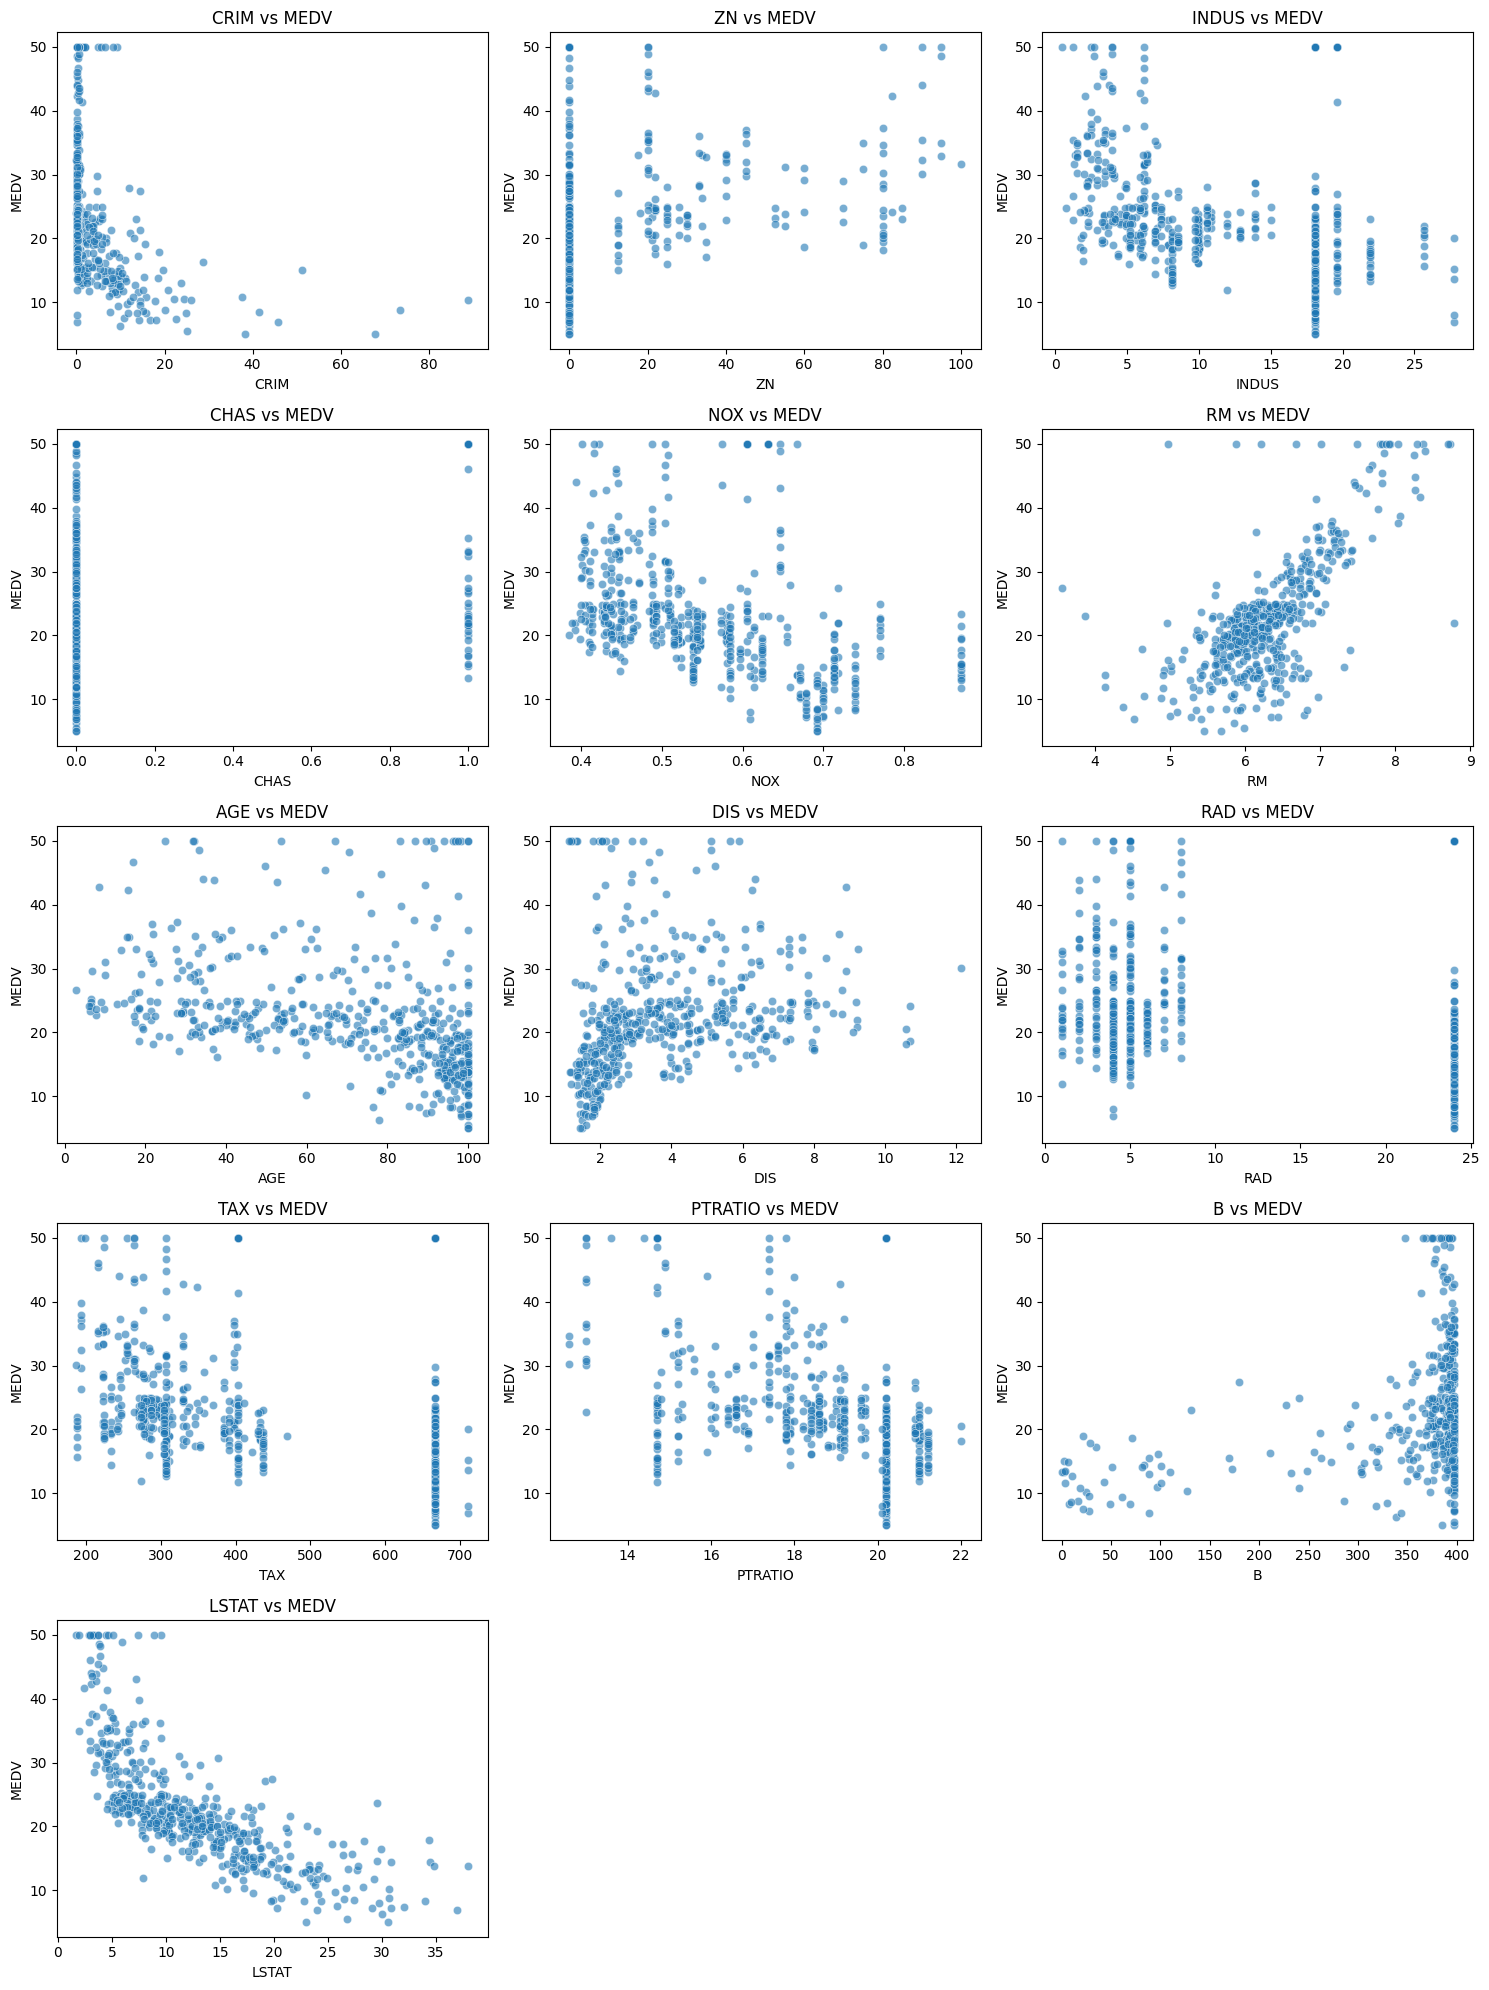

In [ ]:
plot_scatter_variables(housing_df, target='MEDV')

### Heatmaps de correlación

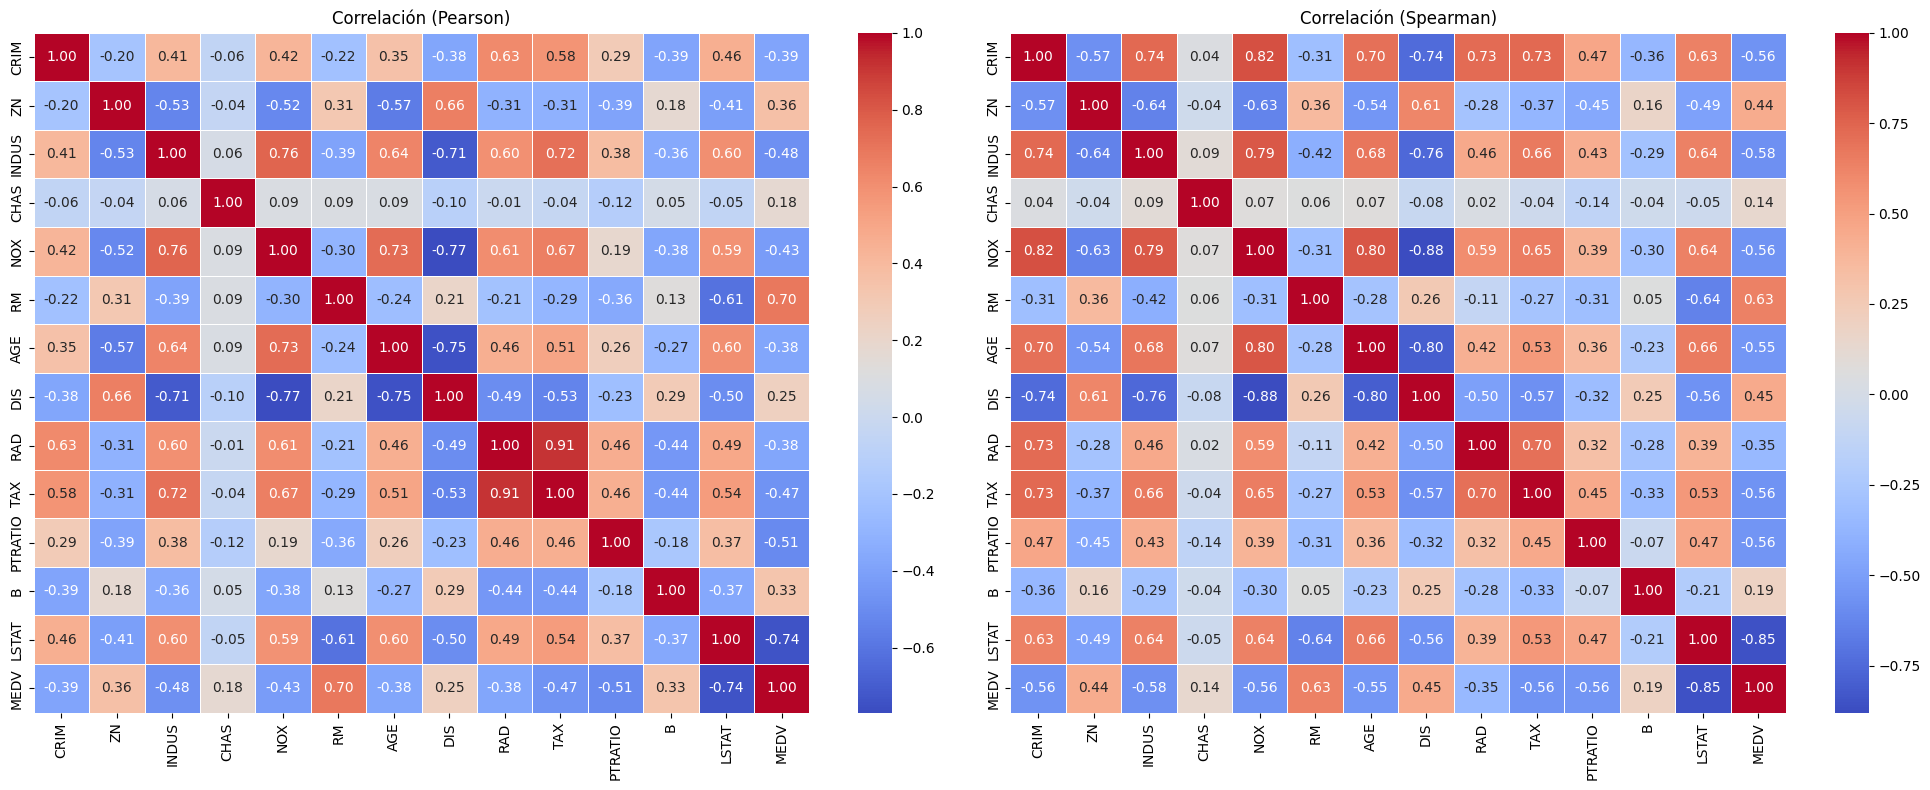

In [ ]:
# Crear una figura con 2 subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson Correlation Heatmap
plot_correlation_heatmap_doble(housing_df, method='pearson', ax=axes[0])

# Spearman Correlation Heatmap
plot_correlation_heatmap_doble(housing_df, method='spearman', ax=axes[1])

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# Linear Regression - Benchmark

In [ ]:
# Definir features y target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir valores
y_pred = model.predict(X_test)

# Evaluar el modelo usando la función personalizada
print_regression_report(y_test, y_pred)


Mean Squared Error : 24.2911194749737
mean Absolute Error : 3.189091965887872
R2 Score : 0.6687594935356296


- El MSE mide el promedio de los errores al cuadrado entre los valores predichos y los valores reales. Como los errores están al cuadrado, penaliza más fuertemente los errores grandes.
    - Dado que la variable objetivo (MEDV) representa el precio de las casas en miles de dólares, un MSE de 24.29 significa que el error cuadrático medio es de aproximadamente $24,290.
- El MAE es el promedio de los errores absolutos entre las predicciones y los valores reales. Es más intuitivo que el MSE porque no penaliza los errores grandes tan severamente.
    - Un MAE de 3.19 significa que, en promedio, tus predicciones están desviadas en $3,190 del valor real de las viviendas.


- La diferencia entre el MAE y el MSE sugiere que hay algunos errores grandes en las predicciones que están influyendo más en el MSE.


- El R² (Coeficiente de Determinación) mide qué tan bien el modelo explica la variabilidad de la variable objetivo.
    - Un R² de 0.669 indica que tu modelo está explicando alrededor del 66.9% de la variabilidad en los precios de las viviendas.


## Linear Regression - OLS

In [ ]:
# Definir las features y el target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Crear y entrenar el modelo OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Mostrar el resumen estadístico del modelo
print(ols_model.summary())

# Predecir valores en el conjunto de prueba
y_pred = ols_model.predict(X_test_sm)

# Usar la función para evaluar el modelo
print_regression_report(y_test, y_pred)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Tue, 11 Feb 2025   Prob (F-statistic):          6.21e-109
Time:                        20:15:39   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2468      5.677      5.328      0.0

## Linear Regression - StandarScaler

In [ ]:
# Definir las features y el target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar StandardScaler a los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame asegurando mantener los mismos índices que los originales
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# Crear y entrenar el modelo OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Mostrar el resumen estadístico del modelo
print(ols_model.summary())

# Predecir valores en el conjunto de prueba
y_pred = ols_model.predict(X_test_sm)

# Evaluar el modelo
print_regression_report(y_test, y_pred)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Tue, 11 Feb 2025   Prob (F-statistic):          6.21e-109
Time:                        20:16:33   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7965      0.236     96.774      0.0

## Regularization L1 - Lasso

In [ ]:
# Definir las features y el target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar StandardScaler a los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame asegurando mantener los mismos índices que los originales
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# Ajustar el modelo OLS con sqrt_lasso
sqrt_lasso_model = sm.OLS(y_train,
                          X_train_sm).fit_regularized(
                                                    # method='sqrt_lasso', 
                                                    alpha=0.2,  # Penalización para la función de costo
                                                    L1_wt=1.0   # Lasso
                                                    )

# Mostrar los coeficientes del modelo sqrt_lasso
print("\nCoeficientes sqrt_lasso:\n", sqrt_lasso_model.params)

# Predecir valores en el conjunto de prueba
y_pred_sqrt_lasso = sqrt_lasso_model.predict(X_test_sm)

# Evaluar el modelo sqrt_lasso
print("\nEvaluación del Modelo sqrt_lasso:")
print_regression_report(y_test, y_pred_sqrt_lasso)


Coeficientes sqrt_lasso:
 const      22.596535
CRIM       -0.493165
ZN          0.000000
INDUS       0.000000
CHAS        0.637582
NOX        -1.053183
RM          3.362257
AGE         0.000000
DIS        -1.618118
RAD         0.000000
TAX         0.000000
PTRATIO    -1.739648
B           0.944455
LSTAT      -3.581859
dtype: float64

Evaluación del Modelo sqrt_lasso:
Mean Squared Error : 27.070160533169933
mean Absolute Error : 3.238576238974234
R2 Score : 0.6308637115585745


## Regularization L2 - Ridge

In [ ]:
# Ajustar el modelo OLS con sqrt_lasso
l2_model = sm.OLS(y_train,
                          X_train_sm).fit_regularized(
                                                    # method='sqrt_lasso', 
                                                    alpha=0.42,  #Penalización para la función de costo
                                                    L1_wt=0   #  Ridge regression
                                                    )

# Mostrar los coeficientes del modelo sqrt_lasso
print("\nCoeficientes:\n", l2_model.params)

# Predecir valores en el conjunto de prueba
y_pred_l2 = l2_model.predict(X_test_sm)

# Evaluar el modelo sqrt_lasso
print("\nEvaluación:")
print_regression_report(y_test, y_pred_l2)


Coeficientes:
 [16.05389764 -0.63440939  0.22072111 -0.40239422  0.76381099 -0.66062469
  2.77258867 -0.17920447 -1.09119508  0.17070342 -0.46311879 -1.43409006
  0.84129241 -2.53288308]

Evaluación:
Mean Squared Error : 72.91276113194125
mean Absolute Error : 6.903058501079052
R2 Score : 0.00574117426154408


## Comparativa L1 - L2

- Probamos cambiando valores de los parámetros de regularización para comparar ambos modelos.

In [ ]:
# Definir las features y el target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar StandardScaler a los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame asegurando mantener los mismos índices que los originales
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# Ajustar el modelo OLS con Lasso (L1 regularization)
lasso_model = sm.OLS(y_train, X_train_sm).fit_regularized(
    # method='sqrt_lasso', 
    alpha=0.001,  # Penalización para la función de costo
    L1_wt=1.0   # Lasso puro
)

# Ajustar el modelo OLS con Ridge (L2 regularization)
ridge_model = sm.OLS(y_train, X_train_sm).fit_regularized(
    # method='sqrt_lasso', 
    alpha=1,  # Misma penalización para comparar con Lasso
    L1_wt=0.0   # Ridge puro
)

# Mostrar los coeficientes etiquetados para Lasso y Ridge
lasso_coefficients = pd.Series(lasso_model.params, index=X_train_sm.columns)
ridge_coefficients = pd.Series(ridge_model.params, index=X_train_sm.columns)

print("\nCoeficientes Lasso:\n", lasso_coefficients)
print("\nCoeficientes Ridge:\n", ridge_coefficients)

# Predecir valores en el conjunto de prueba
y_pred_lasso = lasso_model.predict(X_test_sm)
y_pred_ridge = ridge_model.predict(X_test_sm)

# Función para evaluar el modelo
def print_regression_report_reg(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\nEvaluación del Modelo {model_name}:")
    print(f"Mean Squared Error : {mse}")
    print(f"Mean Absolute Error : {mae}")
    print(f"R2 Score : {r2}")

# Evaluar ambos modelos
print_regression_report_reg(y_test, y_pred_lasso, "Lasso (L1)")
print_regression_report_reg(y_test, y_pred_ridge, "Ridge (L2)")



Coeficientes Lasso:
 const      22.795535
CRIM       -0.999166
ZN          0.691225
INDUS       0.268737
CHAS        0.718899
NOX        -2.015658
RM          3.145933
AGE        -0.173744
DIS        -3.074759
RAD         2.232375
TAX        -1.748310
PTRATIO    -2.035750
B           1.128353
LSTAT      -3.611475
dtype: float64

Coeficientes Ridge:
 const      11.398267
CRIM       -0.545110
ZN          0.230260
INDUS      -0.469851
CHAS        0.651404
NOX        -0.472191
RM          2.161476
AGE        -0.207252
DIS        -0.525565
RAD        -0.117948
TAX        -0.462027
PTRATIO    -1.139410
B           0.654438
LSTAT      -1.909591
dtype: float64

Evaluación del Modelo Lasso (L1):
Mean Squared Error : 24.29555009736806
Mean Absolute Error : 3.18799953922518
R2 Score : 0.668699076328124

Evaluación del Modelo Ridge (L2):
Mean Squared Error : 155.45802506708708
Mean Absolute Error : 11.274137425224211
R2 Score : -1.1198691567189898


## Feature Selection

### Forward Feature Selection

In [ ]:
# Definir las features y el target SIN ESCALAR
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
linear_model = LinearRegression()

# Aplicar Forward Feature Selection usando R² como métrica
sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select='auto',      # Selecciona automáticamente el número óptimo de características
    direction='forward',              # Selección hacia adelante
    scoring='r2',                     # Usar R² como métrica
    tol=1e-5,                         # Tolerancia para detener la selección
    cv=5,                             # Validación cruzada para mejor evaluación
    n_jobs=-1                         # Usar todos los núcleos disponibles
)

# Ajustar el selector al conjunto de entrenamiento
sfs.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[sfs.get_support()]

print("\nCaracterísticas Seleccionadas por Forward Feature Selection:")
print(selected_features)

# Entrenar un modelo usando solo las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

linear_model.fit(X_train_selected, y_train)

# Predicciones en ambos conjuntos
y_pred_train = linear_model.predict(X_train_selected)
y_pred_test = linear_model.predict(X_test_selected)

# Evaluar el modelo en el conjunto de entrenamiento
print_regression_report_reg(y_train, y_pred_train, "Entrenamiento")

# Evaluar el modelo en el conjunto de prueba
print_regression_report_reg(y_test, y_pred_test, "Prueba")



Características Seleccionadas por Forward Feature Selection:
Index(['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT'],
      dtype='object')

Evaluación del Modelo Entrenamiento:
Mean Squared Error : 21.865461338787117
Mean Absolute Error : 3.341881886656635
R2 Score : 0.748306611988744

Evaluación del Modelo Prueba:
Mean Squared Error : 25.500212598176194
Mean Absolute Error : 3.265642056805143
R2 Score : 0.6522719611720098


### Backward Feature Selection

In [ ]:
# Definir las features y el target SIN ESCALAR
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión lineal
linear_model = LinearRegression()

# Aplicar Forward Feature Selection usando R² como métrica
sfs = SequentialFeatureSelector(
    linear_model,
    n_features_to_select='auto',      # Selecciona automáticamente el número óptimo de características
    direction='backward',              # Selección hacia atrás
    scoring='r2',                     # Usar R² como métrica
    tol=1e-5,                         # Tolerancia para detener la selección
    cv=5,                             # Validación cruzada para mejor evaluación
    n_jobs=-1                         # Usar todos los núcleos disponibles
)

# Ajustar el selector al conjunto de entrenamiento
sfs.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[sfs.get_support()]

print("\nCaracterísticas Seleccionadas por Backward Feature Selection:")
print(selected_features)

# Entrenar un modelo usando solo las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

linear_model.fit(X_train_selected, y_train)

# Predicciones en ambos conjuntos
y_pred_train = linear_model.predict(X_train_selected)
y_pred_test = linear_model.predict(X_test_selected)

# Evaluar el modelo en el conjunto de entrenamiento
print_regression_report_reg(y_train, y_pred_train, "Entrenamiento")

# Evaluar el modelo en el conjunto de prueba
print_regression_report_reg(y_test, y_pred_test, "Prueba")



Características Seleccionadas por Backward Feature Selection:
Index(['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT'],
      dtype='object')

Evaluación del Modelo Entrenamiento:
Mean Squared Error : 21.865461338787117
Mean Absolute Error : 3.341881886656635
R2 Score : 0.748306611988744

Evaluación del Modelo Prueba:
Mean Squared Error : 25.500212598176194
Mean Absolute Error : 3.265642056805143
R2 Score : 0.6522719611720098


### Regularization Paths - Path Plots

#### L1

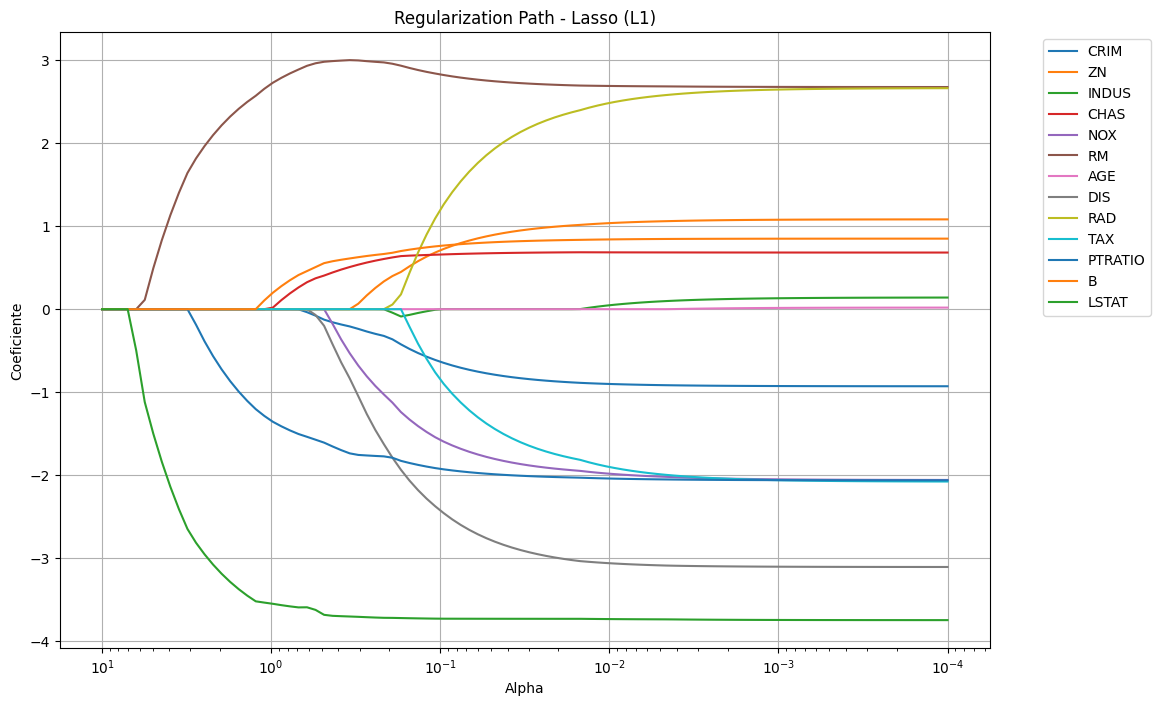

In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = housing_df['MEDV'].values

# Calcular el Lasso path (trayectoria de regularización)
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y, alphas=np.logspace(-4, 1, 100))

# Graficar
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X.columns):
    plt.plot(alphas_lasso, coefs_lasso[i], label=feature)

plt.xscale('log')
plt.gca().invert_xaxis()  # Invertir el eje X para que alpha vaya de pequeño a grande
plt.xlabel('Alpha')
plt.ylabel('Coeficiente')
plt.title('Regularization Path - Lasso (L1)')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)
plt.show()


#### L2

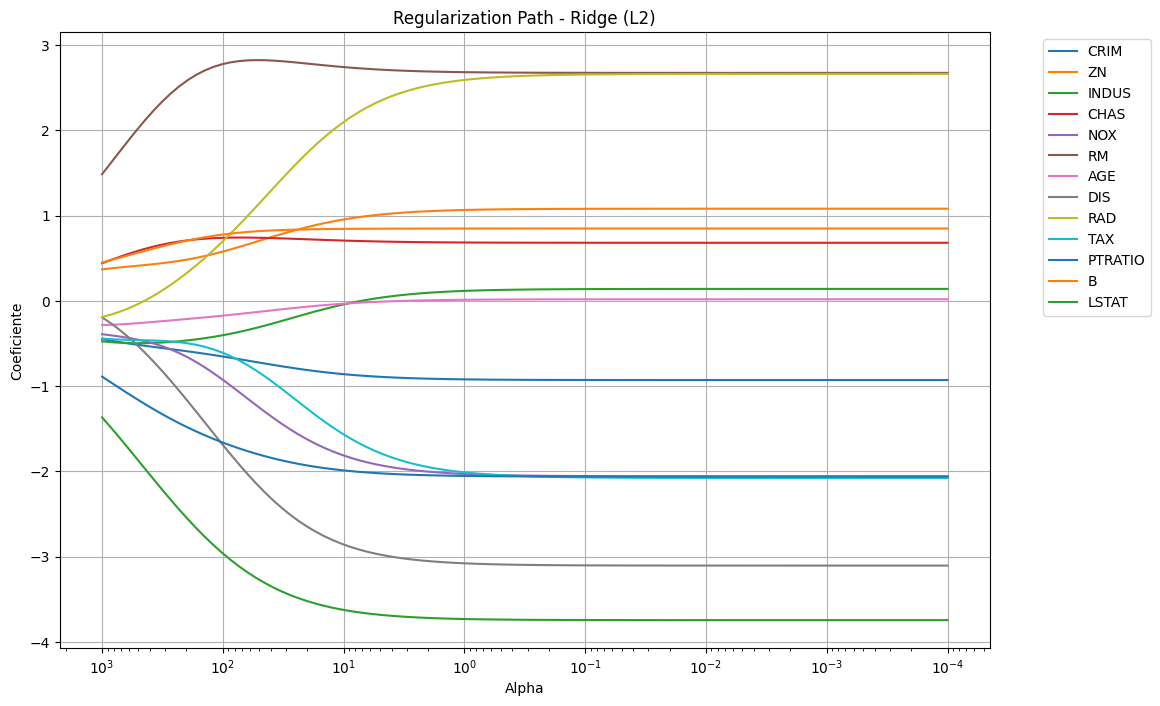

In [ ]:
alphas_ridge = np.logspace(-4, 3, 100)
coefs_ridge = []

for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    coefs_ridge.append(ridge.coef_)

# Convertir a array para graficar
coefs_ridge = np.array(coefs_ridge)

# Graficar
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X.columns):
    plt.plot(alphas_ridge, coefs_ridge[:, i], label=feature)

plt.xscale('log')
plt.gca().invert_xaxis()  # Invertir el eje X para que alpha vaya de pequeño a grande
plt.xlabel('Alpha')
plt.ylabel('Coeficiente')
plt.title('Regularization Path - Ridge (L2)')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)
plt.show()


## Transformación de variables

In [ ]:
# Añadimos 1 para evitar log(0) en caso de que haya valores muy pequeños
housing_df['LSTAT_log'] = np.log(housing_df['LSTAT'] + 1)
housing_df['DIS_log']   = np.log(housing_df['DIS']   + 1)
housing_df['NOX_log']   = np.log(housing_df['NOX']   + 1)

In [ ]:
housing_df['INDUS_log'] = np.log(housing_df['INDUS'] + 1)

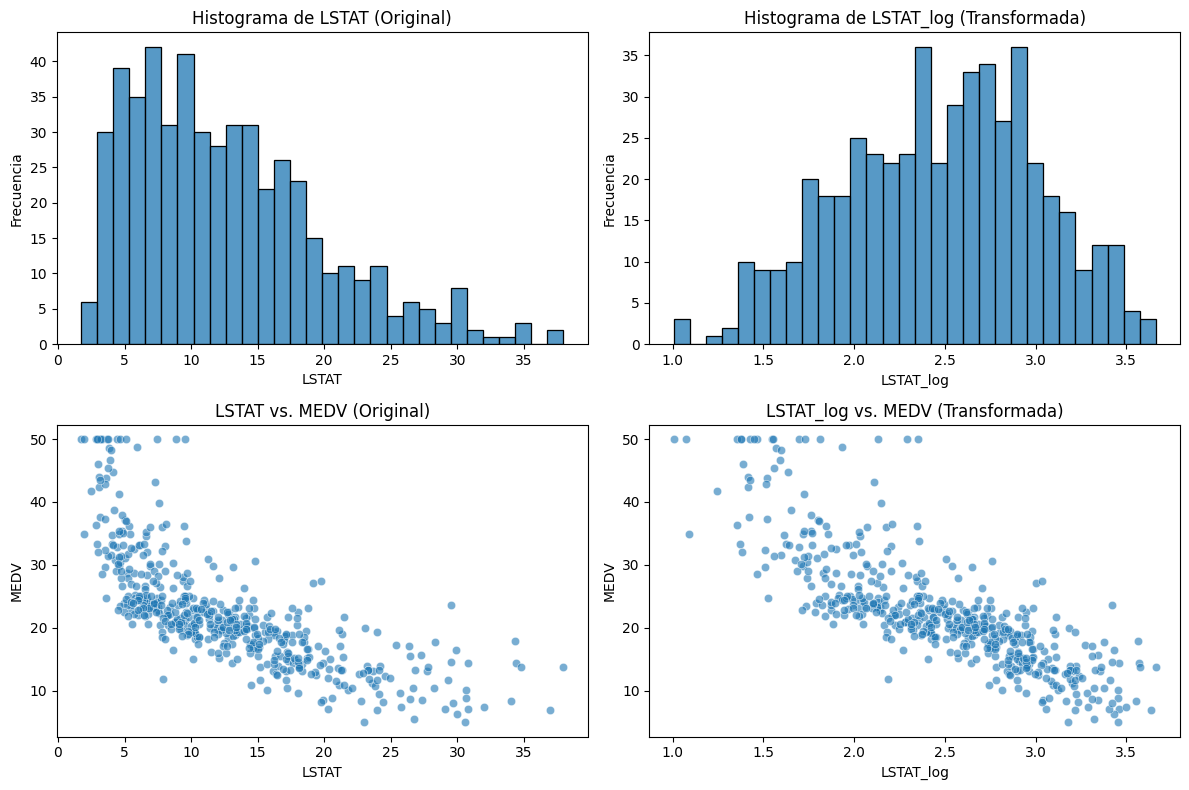

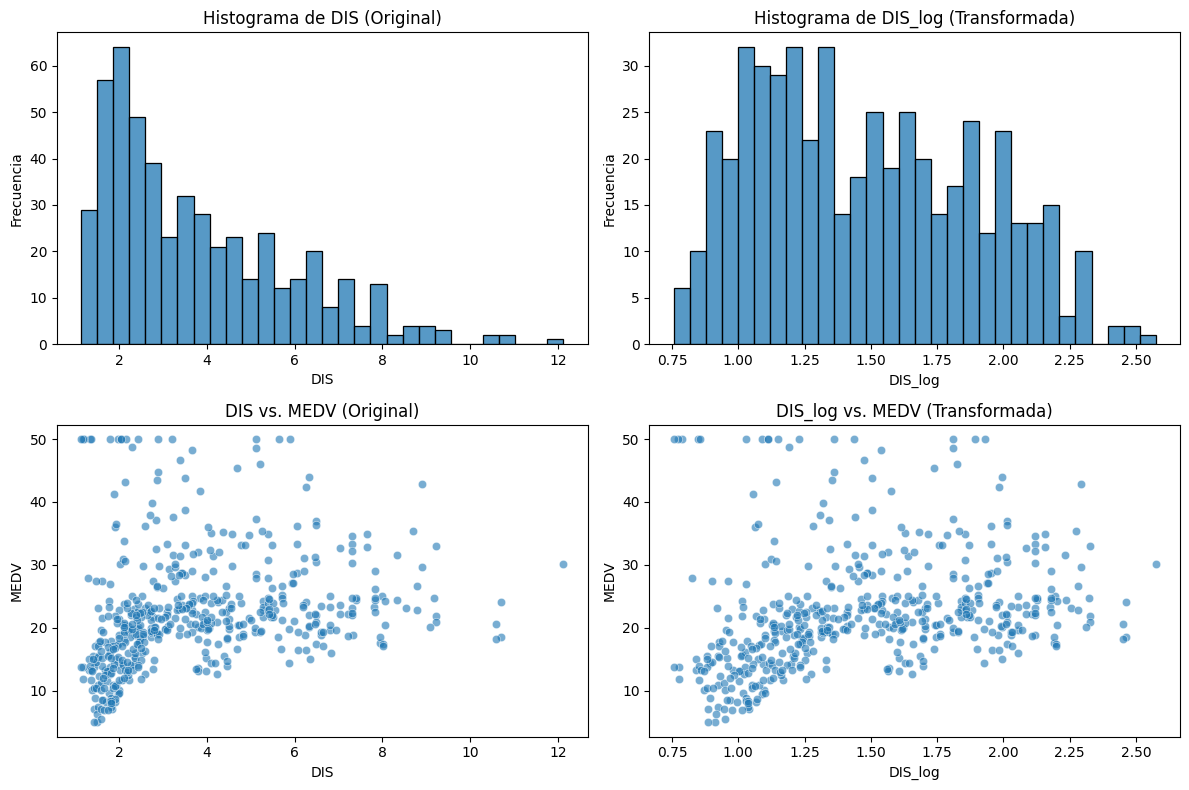

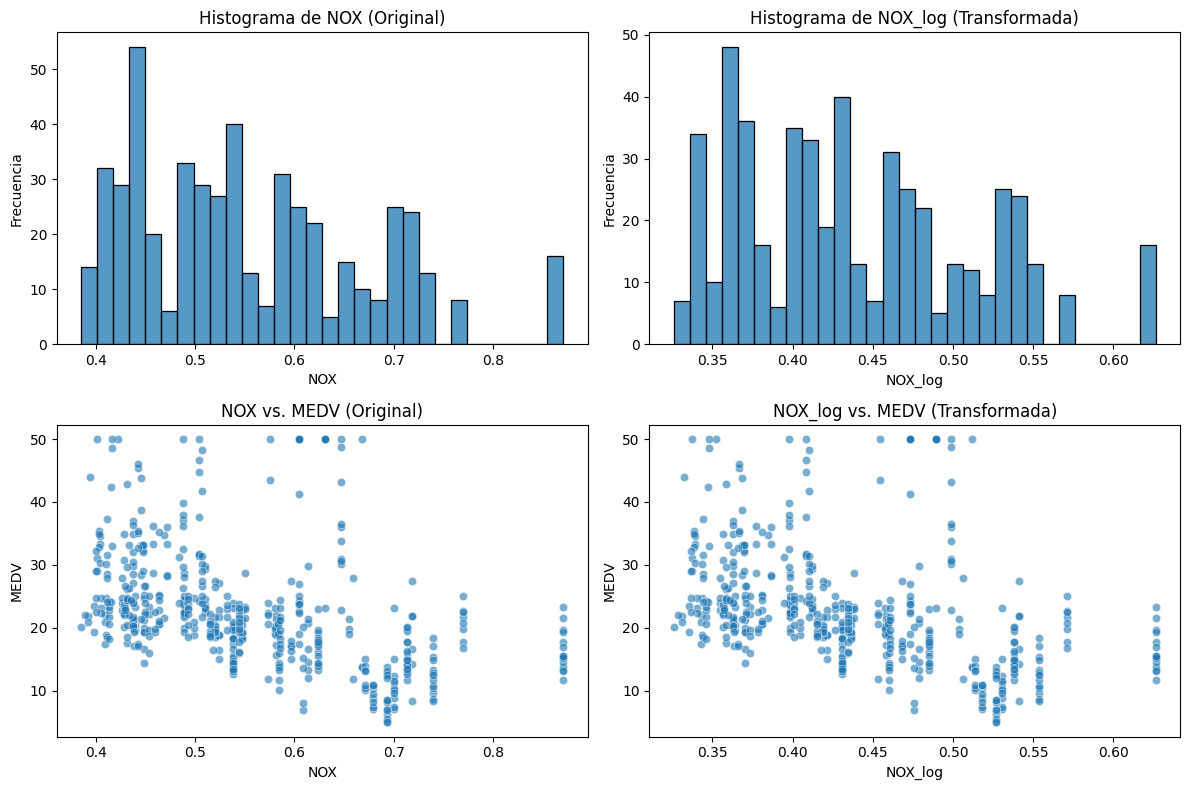

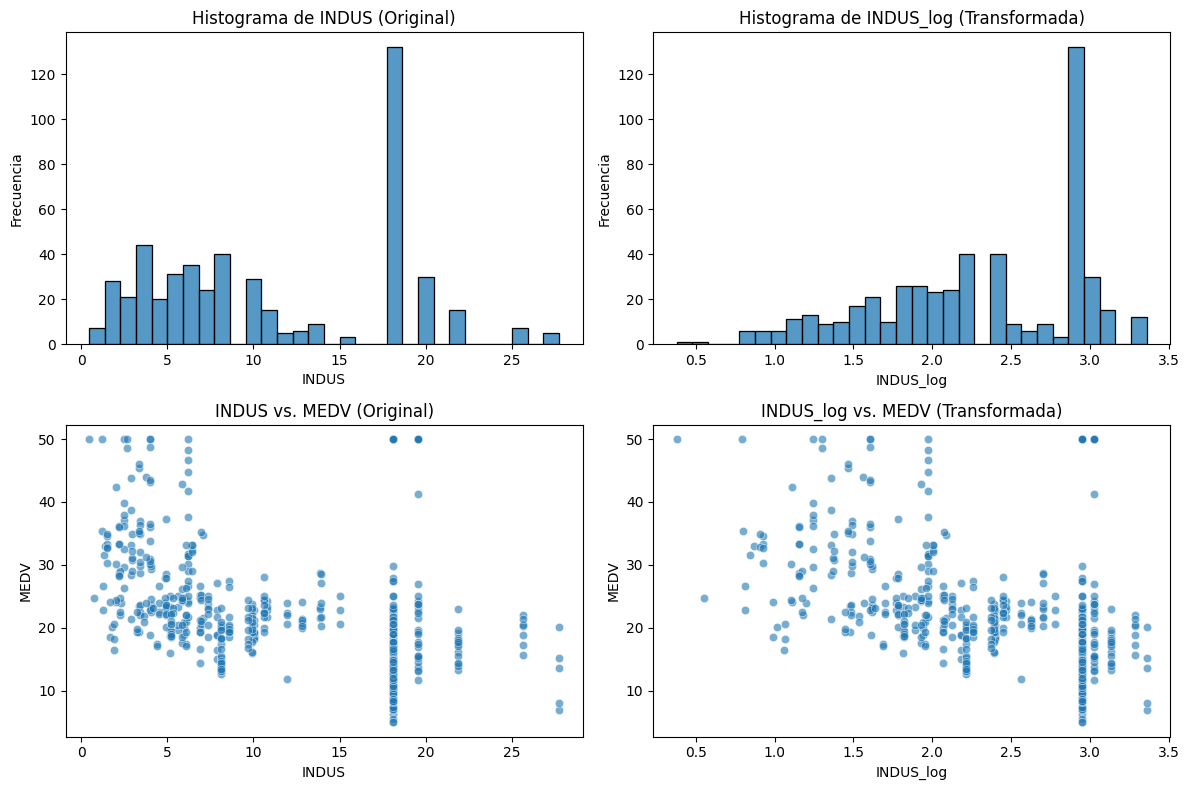

In [ ]:
pairs = [
    ('LSTAT', 'LSTAT_log'),
    ('DIS',   'DIS_log'),
    ('NOX',   'NOX_log'),
    ('INDUS', 'INDUS_log'),
]

plot_comparison_original_transformed(
    df=housing_df, 
    target='MEDV', 
    pairs=pairs,
    bins=30
)

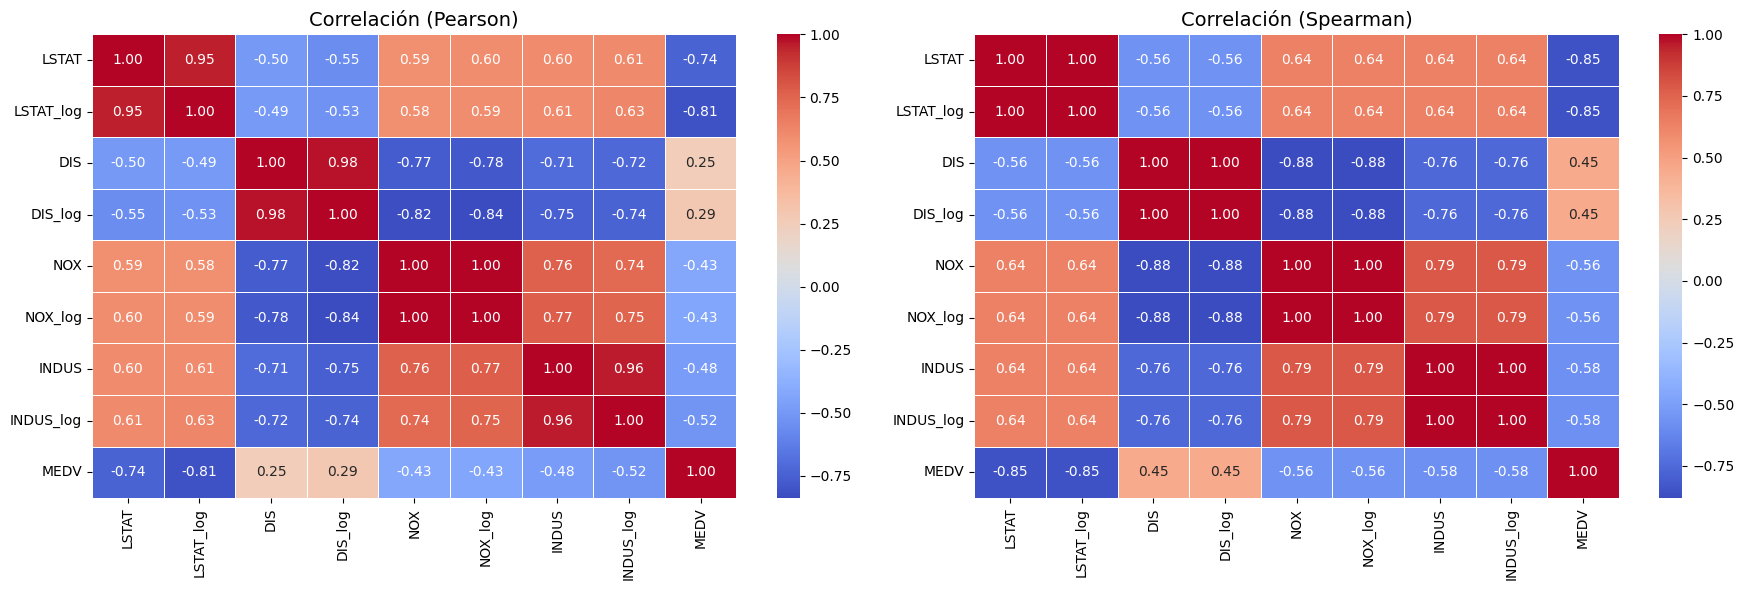

In [ ]:
# Seleccionamos columnas de interés para ver la comparación
cols_of_interest = [
    'LSTAT', 'LSTAT_log',
    'DIS',   'DIS_log',
    'NOX',   'NOX_log',
    'INDUS', 'INDUS_log',
    'MEDV'
]

plot_correlation_heatmaps_side_by_side(
    df=housing_df,
    columns=cols_of_interest,
    methods=('pearson', 'spearman')
)

## Nuevo modelo con LSTAT_log y sin LSTAT

In [ ]:
X_new = housing_df.drop(['MEDV', 'LSTAT', 'DIS', 'INDUS', 'NOX'], axis=1)
y_new = housing_df['MEDV']

# 2. Dividir en conjunto de entrenamiento y prueba
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, 
    y_new, 
    test_size=0.2, 
    random_state=42
)

# 3. Escalado (StandardScaler) a los datos de entrenamiento y test
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

# 4. Convertir a DataFrame escalado, conservando columnas e índices
X_train_scaled_new = pd.DataFrame(X_train_scaled_new, 
                                  columns=X_train_new.columns, 
                                  index=X_train_new.index)
X_test_scaled_new = pd.DataFrame(X_test_scaled_new, 
                                 columns=X_test_new.columns, 
                                 index=X_test_new.index)

# 5. Agregar la constante para el intercepto
X_train_sm_new = sm.add_constant(X_train_scaled_new)
X_test_sm_new = sm.add_constant(X_test_scaled_new)

# 6. Crear y entrenar el modelo OLS con 'LSTAT_log' (y SIN 'LSTAT')
ols_model_new = sm.OLS(y_train_new, X_train_sm_new).fit()

# 7. Mostrar el resumen estadístico del modelo
print(ols_model_new.summary())

# 8. Predecir valores en el conjunto de prueba
y_pred_new = ols_model_new.predict(X_test_sm_new)

# 9. Evaluar el modelo (usando tu función 'print_regression_report')
print_regression_report(y_test_new, y_pred_new)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     124.4
Date:                Tue, 11 Feb 2025   Prob (F-statistic):          8.43e-130
Time:                        20:27:48   Log-Likelihood:                -1144.2
No. Observations:                 404   AIC:                             2316.
Df Residuals:                     390   BIC:                             2372.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7965      0.208    109.570      0.0

## SGDRegressor

- descenso por gradiente estocástico

In [ ]:
X_new = housing_df.drop(['MEDV', 'LSTAT', 'DIS', 'INDUS', 'NOX'], axis=1)
y_new = housing_df['MEDV']

# 2. Dividir en entrenamiento y prueba
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new,
    y_new,
    test_size=0.2,
    random_state=42
)

# 3. Escalar características
scaler = StandardScaler()
X_train_scaled_new = scaler.fit_transform(X_train_new)
X_test_scaled_new = scaler.transform(X_test_new)

# (Opcional) Si quieres convertirlos de nuevo a DataFrame (solo es necesario si deseas
# preservar las columnas/índices, aunque no es estrictamente requerido para SGDRegressor).
X_train_scaled_new = pd.DataFrame(X_train_scaled_new, 
                                  columns=X_train_new.columns, 
                                  index=X_train_new.index)
X_test_scaled_new = pd.DataFrame(X_test_scaled_new, 
                                 columns=X_test_new.columns, 
                                 index=X_test_new.index)

# ---------------------------------------------------------
# EJEMPLO 1: Usar statsmodels.OLS (como en tu código original)
# ---------------------------------------------------------
X_train_sm_new = sm.add_constant(X_train_scaled_new)
X_test_sm_new = sm.add_constant(X_test_scaled_new)
ols_model_new = sm.OLS(y_train_new, X_train_sm_new).fit()
y_pred_ols = ols_model_new.predict(X_test_sm_new)

# (Asumimos que tienes una función print_regression_report)
print("Resultados con OLS (statsmodels):")
print(ols_model_new.summary())
print_regression_report(y_test_new, y_pred_ols)

# ---------------------------------------------------------
# EJEMPLO 2: Usar SGDRegressor (descenso por gradiente estocástico)
# ---------------------------------------------------------
sgd_reg = SGDRegressor(
    loss='epsilon_insensitive',  # Epsilon-insensitive
    shuffle=True,               # Activar el mezclado aleatorio
    epsilon=0.0001,           # Constante de regularización
    penalty='elasticnet',          # Regularización L2 (Ridge) elasticnet=ambas
    max_iter=10000000,         # Número máximo de iteraciones
    tol=1e-9,              # Criterio de tolerancia para terminar
    random_state=42, 
    alpha=0.001,          # Constante de regularización
    learning_rate='constant',  # Tipo de aprendizaje 'constant', 'invscaling', 'adaptive' u 'optimal'.
    eta0=0.001,             # Constante de aprendizaje
    power_t=0.08,           # Constante de aprendizaje
)

# Entrenamos el modelo con los datos de entrenamiento escalados
sgd_reg.fit(X_train_scaled_new, y_train_new)

# Realizamos predicciones sobre los datos de prueba
y_pred_sgd = sgd_reg.predict(X_test_scaled_new)

print("\nResultados con SGDRegressor:")
print_regression_report(y_test_new, y_pred_sgd)

# Si deseas revisar los coeficientes del modelo
print("\nCoeficientes del modelo SGD:")
for col, coef in zip(X_train_scaled_new.columns, sgd_reg.coef_):
    print(f"{col}: {coef}")
print(f"Intercepto (bias): {sgd_reg.intercept_}")


Resultados con OLS (statsmodels):
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     124.4
Date:                Tue, 11 Feb 2025   Prob (F-statistic):          8.43e-130
Time:                        20:29:04   Log-Likelihood:                -1144.2
No. Observations:                 404   AIC:                             2316.
Df Residuals:                     390   BIC:                             2372.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7

# Random Forest Regression

## Benchamark

In [12]:
# Supongamos que housing_df está definido y contiene todas las columnas, incluyendo la variable objetivo 'MEDV'
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear y entrenar el modelo RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en Train y Test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluar el modelo
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")


=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 1.9784
Mean Absolute Error (MAE): 0.9035
R2 Score: 0.9772
RMSE: 1.4066

=== Evaluación en TEST ===
Mean Squared Error (MSE): 7.9015
Mean Absolute Error (MAE): 2.0395
R2 Score: 0.8923
RMSE: 2.8110


## MDI - MDA

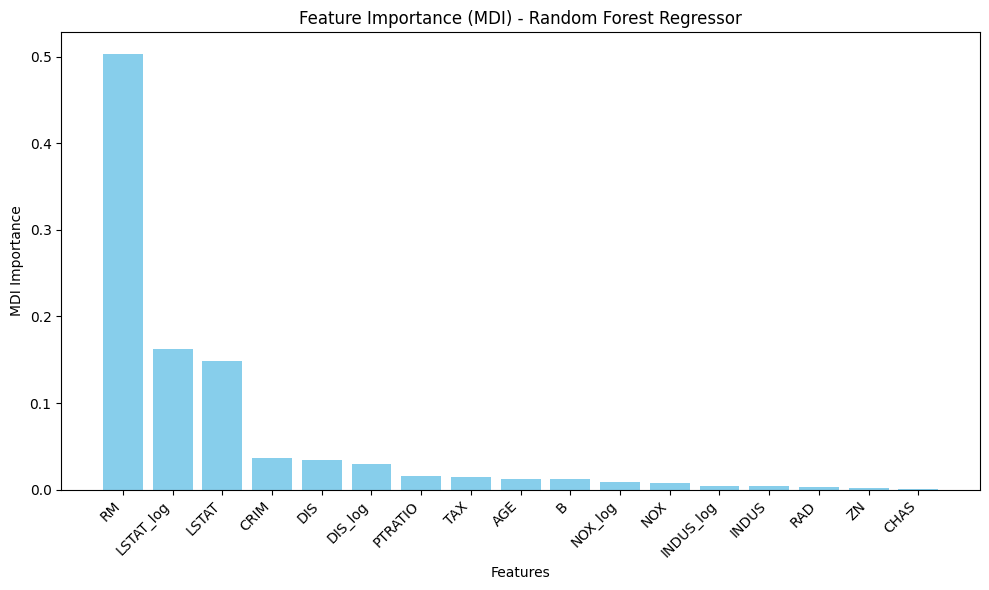

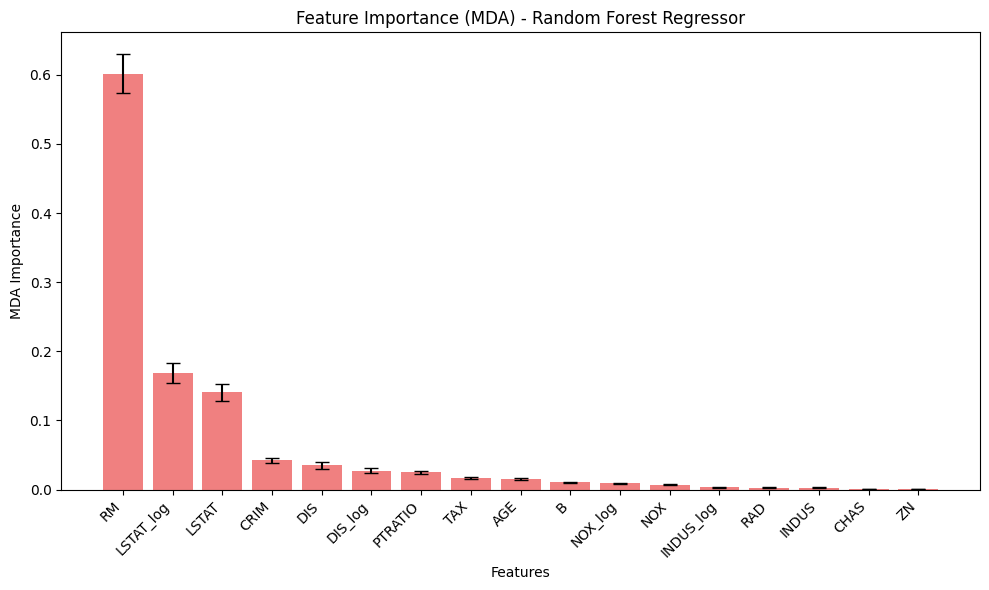

In [ ]:
mdi_regressor(X_train, y_train)
mda_regressor(X_train, y_train)

### GridSearchCV con las variables seleccionadas en Top 3 MDI

In [ ]:
# Definir las variables seleccionadas en Top 3 MDI
top3_mdi = ["RM", "LSTAT", "CRIM"]

# Filtrar las variables en los datasets
X_train_selected = X_train[top3_mdi]
X_test_selected = X_test[top3_mdi]

# Definir la grilla de hiperparámetros incluyendo tolerancias
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],   # Número de árboles
    'max_depth': [None, 10, 20, 25],            # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],            # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4, 8],           # Mínimo de muestras en hojas
    'max_features': ['sqrt', 'log2', 0.5, 0.75], # Número de características a considerar
    'bootstrap': [True, False]                  # Si se usa muestreo con reemplazo
}

# Aplicar GridSearchCV con RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_selected, y_train)

# Mostrar mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Evaluar el modelo
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 5.8070
Mean Absolute Error (MAE): 1.7187
R2 Score: 0.9332
RMSE: 2.4098

=== Evaluación en TEST ===
Mean Squared Error (MSE): 13.5360
Mean Absolute Error (MAE): 2.4586
R2 Score: 0.8154
RMSE: 3.6791


## Forward Feature Selection

In [ ]:
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Aplicar Forward Feature Selection
ffs = SequentialFeatureSelector(
    rf_model,
    n_features_to_select="auto",  # Puede ser un número o "auto" para detener cuando no mejora
    direction="forward",
    scoring="r2",  # Maximizar R²
    cv=5,  # Cross-validation
    n_jobs=-1
)
ffs.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[ffs.get_support()]
print("Características seleccionadas:", list(selected_features))

# Filtrar las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Entrenar el modelo con las características seleccionadas
rf_model.fit(X_train_selected, y_train)

# Hacer predicciones en Train y Test
y_train_pred = rf_model.predict(X_train_selected)
y_test_pred = rf_model.predict(X_test_selected)

# Evaluar el modelo
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Características seleccionadas: ['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT_log', 'NOX_log']

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 1.8923
Mean Absolute Error (MAE): 0.8965
R2 Score: 0.9782
RMSE: 1.3756

=== Evaluación en TEST ===
Mean Squared Error (MSE): 8.3171
Mean Absolute Error (MAE): 2.0257
R2 Score: 0.8866
RMSE: 2.8839


## Backward Feature Selection

In [13]:
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Aplicar Backward Feature Selection
bfs = SequentialFeatureSelector(
    rf_model,
    n_features_to_select="auto",  # Puede ser un número o "auto" para detener cuando no mejora
    direction="backward",  # Backward stepwise selection
    scoring="r2",  # Maximizar R²
    cv=5,  # Cross-validation
    n_jobs=-1
)
bfs.fit(X_train, y_train)

# Obtener las características seleccionadas
selected_features = X_train.columns[bfs.get_support()]
print("Características seleccionadas:", list(selected_features))

# Filtrar las características seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Entrenar el modelo con las características seleccionadas
rf_model.fit(X_train_selected, y_train)

# Hacer predicciones en Train y Test
y_train_pred = rf_model.predict(X_train_selected)
y_test_pred = rf_model.predict(X_test_selected)

# Evaluar el modelo con la función optimizada
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Características seleccionadas: ['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 1.9365
Mean Absolute Error (MAE): 0.9120
R2 Score: 0.9777
RMSE: 1.3916

=== Evaluación en TEST ===
Mean Squared Error (MSE): 8.2807
Mean Absolute Error (MAE): 2.0274
R2 Score: 0.8871
RMSE: 2.8776


## Modelo con las 3 variables principales


In [ ]:
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Definir las tres principales variables de cada método
top3_forward = ["NOX", "RM", "DIS"]
top3_backward = ["INDUS", "NOX", "RM"]

# Filtrar las variables en los datasets
X_train_forward = X_train[top3_forward]
X_test_forward = X_test[top3_forward]

X_train_backward = X_train[top3_backward]
X_test_backward = X_test[top3_backward]

# Definir y entrenar los modelos
rf_forward = RandomForestRegressor(random_state=42)
rf_forward.fit(X_train_forward, y_train)

rf_backward = RandomForestRegressor(random_state=42)
rf_backward.fit(X_train_backward, y_train)

# Realizar predicciones en Train y Test
y_train_pred_forward = rf_forward.predict(X_train_forward)
y_test_pred_forward = rf_forward.predict(X_test_forward)

y_train_pred_backward = rf_backward.predict(X_train_backward)
y_test_pred_backward = rf_backward.predict(X_test_backward)

# Calcular métricas en Train (Forward)
metrics_train_forward = {
    "MSE": mean_squared_error(y_train, y_train_pred_forward),
    "MAE": mean_absolute_error(y_train, y_train_pred_forward),
    "R2 Score": r2_score(y_train, y_train_pred_forward),
    "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred_forward))
}

# Calcular métricas en Test (Forward)
metrics_test_forward = {
    "MSE": mean_squared_error(y_test, y_test_pred_forward),
    "MAE": mean_absolute_error(y_test, y_test_pred_forward),
    "R2 Score": r2_score(y_test, y_test_pred_forward),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_forward))
}

# Calcular métricas en Train (Backward)
metrics_train_backward = {
    "MSE": mean_squared_error(y_train, y_train_pred_backward),
    "MAE": mean_absolute_error(y_train, y_train_pred_backward),
    "R2 Score": r2_score(y_train, y_train_pred_backward),
    "RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred_backward))
}

# Calcular métricas en Test (Backward)
metrics_test_backward = {
    "MSE": mean_squared_error(y_test, y_test_pred_backward),
    "MAE": mean_absolute_error(y_test, y_test_pred_backward),
    "R2 Score": r2_score(y_test, y_test_pred_backward),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_backward))
}

# Crear tabla comparativa
models_comparison_df = pd.DataFrame({
    "Modelo": ["Top 3 Forward Selection (Train)", "Top 3 Forward Selection (Test)",
               "Top 3 Backward Selection (Train)", "Top 3 Backward Selection (Test)"],
    "Características Seleccionadas": [str(top3_forward), str(top3_forward), 
                                      str(top3_backward), str(top3_backward)],
    "MSE": [metrics_train_forward["MSE"], metrics_test_forward["MSE"], 
            metrics_train_backward["MSE"], metrics_test_backward["MSE"]],
    "MAE": [metrics_train_forward["MAE"], metrics_test_forward["MAE"], 
            metrics_train_backward["MAE"], metrics_test_backward["MAE"]],
    "R2 Score": [metrics_train_forward["R2 Score"], metrics_test_forward["R2 Score"], 
                 metrics_train_backward["R2 Score"], metrics_test_backward["R2 Score"]],
    "RMSE": [metrics_train_forward["RMSE"], metrics_test_forward["RMSE"], 
             metrics_train_backward["RMSE"], metrics_test_backward["RMSE"]]
})

# Mostrar resultados
models_comparison_df


,Modelo,Características Seleccionadas,MSE,MAE,R2 Score,RMSE
0,Top 3 Forward Selection (Train),"['NOX', 'RM', 'DIS']",3.487706,1.155550,0.959853,1.867540
1,Top 3 Forward Selection (Test),"['NOX', 'RM', 'DIS']",17.245648,2.623980,0.764834,4.152788
2,Top 3 Backward Selection (Train),"['INDUS', 'NOX', 'RM']",3.670295,1.177528,0.957751,1.915801
3,Top 3 Backward Selection (Test),"['INDUS', 'NOX', 'RM']",16.652394,2.705105,0.772923,4.080734


## GridSearchCV sobre TOP 3 Forward Selection

In [ ]:
# Definir las variables seleccionadas en Top 3 Forward Selection
top3_forward = ["NOX", "RM", "DIS"]

# Filtrar las variables en los datasets
X_train_selected = X_train[top3_forward]
X_test_selected = X_test[top3_forward]

# Definir la grilla de hiperparámetros incluyendo tolerancias
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],           # Número de árboles
    'max_depth': [None, 5, 6, 7, 8, 10, 20],            # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10, 15],                # Mínimo de muestras para dividir
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 10],      # Mínimo de muestras en hojas
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.75],   # Número de características a considerar
    'max_samples': [0.25, 0.5, 0.6, 0.75, 1.0],         # Porcentaje de muestras usadas en cada árbol - Solo si bootstrap=True
    'bootstrap': [True]                                 # Si se usa muestreo con reemplazo
}

# Aplicar GridSearchCV con RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_selected, y_train)

# Mostrar mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Evaluar el modelo con la función optimizada
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Fitting 5 folds for each of 28000 candidates, totalling 140000 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 7, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 10.0224
Mean Absolute Error (MAE): 2.1413
R2 Score: 0.8846
RMSE: 3.1658

=== Evaluación en TEST ===
Mean Squared Error (MSE): 13.4226
Mean Absolute Error (MAE): 2.4507
R2 Score: 0.8170
RMSE: 3.6637


Primeros resultados:
```
Mejores Hiperparámetros: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== Evaluación con GridSearchCV ===

=== TRAIN ===
Mean Squared Error (MSE): 1.1689029596187817
Mean Absolute Error (MAE): 0.7677291480003962
R2 Score: 0.9865447546884847
RMSE: 1.081158156616682

=== TEST ===
Mean Squared Error (MSE): 10.210050823470356
Mean Absolute Error (MAE): 2.288436460585329
R2 Score: 0.8607728882451209
RMSE: 3.1953170145496292
```

---

Segundos resultados con más parámetros:
```
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 7, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

=== Evaluación con GridSearchCV ===

=== TRAIN ===
Mean Squared Error (MSE): 10.022410392989489
Mean Absolute Error (MAE): 2.14133651045933
R2 Score: 0.8846320052997941
RMSE: 3.1658190714236163

=== TEST ===
Mean Squared Error (MSE): 13.422641758446765
Mean Absolute Error (MAE): 2.450722319517002
R2 Score: 0.8169650987580708
RMSE: 3.6636923667861043
```

### GridSearchCV optimizando RMSE

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Definir las variables seleccionadas en Top 3 Forward Selection
top3_forward = ["NOX", "RM", "DIS"]

# Filtrar las variables en los datasets
X_train_selected = X_train[top3_forward]
X_test_selected = X_test[top3_forward]

# Definir la grilla de hiperparámetros optimizando RMSE
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],           # Número de árboles
    'max_depth': [None, 5, 7, 8, 10, 20],               # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10, 15],                # Mínimo de muestras para dividir
    'min_samples_leaf': [2, 5, 7, 10],                  # Mínimo de muestras en hojas
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.75],   # Número de características a considerar
    'max_samples': [0.25, 0.5, 0.6, 0.75, 1.0],         # Porcentaje de muestras usadas en cada árbol
    'bootstrap': [True]                                 # Muestreo con reemplazo
}

# Aplicar GridSearchCV con RMSE como métrica de optimización
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_selected, y_train)

# Mostrar mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Evaluar el modelo con la función optimizada
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")


Fitting 5 folds for each of 12000 candidates, totalling 60000 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 7, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 10.0224
Mean Absolute Error (MAE): 2.1413
R2 Score: 0.8846
RMSE: 3.1658

=== Evaluación en TEST ===
Mean Squared Error (MSE): 13.4226
Mean Absolute Error (MAE): 2.4507
R2 Score: 0.8170
RMSE: 3.6637


## Gridsearch sobre Top 3 Backward Selection

In [ ]:
# Definir las variables seleccionadas en Top 3 Backward Selection
top3_backward = ["INDUS", "NOX", "RM"]

# Filtrar las variables en los datasets
X_train_selected = X_train[top3_backward]
X_test_selected = X_test[top3_backward]

# Definir la grilla de hiperparámetros incluyendo tolerancias
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],   # Número de árboles
    'max_depth': [None, 10, 20, 25],            # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],            # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4, 8],           # Mínimo de muestras en hojas
    'max_features': ['sqrt', 'log2', 0.5, 0.75],# Número de características a considerar
    'bootstrap': [True, False]                  # Si se usa muestreo con reemplazo
}

# Aplicar GridSearchCV con RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_selected, y_train)

# Mostrar mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Evaluar el modelo con la función optimizada
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 3.8768
Mean Absolute Error (MAE): 1.3899
R2 Score: 0.9554
RMSE: 1.9690

=== Evaluación en TEST ===
Mean Squared Error (MSE): 13.7151
Mean Absolute Error (MAE): 2.4936
R2 Score: 0.8130
RMSE: 3.7034


## GridSearch con los parámetros indicados en clase

In [14]:
# Definir las variables seleccionadas en Top 3 Forward Selection
top3_forward = ["NOX", "RM", "DIS"]

# Filtrar las variables en los datasets
X_train_selected = X_train[top3_forward]
X_test_selected = X_test[top3_forward]

# Definir la grilla de hiperparámetros incluyendo tolerancias
param_grid = {
    'n_estimators': [50, 100, 200, 250, 300],       # Número de árboles
    'max_depth': [5, 10, 20],                       # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10, 15],            # Mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4],                  # Mínimo de muestras en hojas
    # 'max_features': ['sqrt', 'log2', None],       # Número de características a considerar 
    'bootstrap': [True, False]                      # Si se usa muestreo con reemplazo
}

# Aplicar GridSearchCV con RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Ajustar el modelo con las características seleccionadas
grid_search.fit(X_train_selected, y_train)

# Mostrar mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Evaluar el modelo con la función optimizada
print_regression_report_with_rmse(y_train, y_train_pred, dataset_name="TRAIN")
print_regression_report_with_rmse(y_test, y_test_pred, dataset_name="TEST")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Mejores Hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

=== Evaluación en TRAIN ===
Mean Squared Error (MSE): 4.3088
Mean Absolute Error (MAE): 1.4222
R2 Score: 0.9504
RMSE: 2.0758

=== Evaluación en TEST ===
Mean Squared Error (MSE): 16.5627
Mean Absolute Error (MAE): 2.5837
R2 Score: 0.7741
RMSE: 4.0697


# Categorización de variables numéricas

### Revisamos histogramas

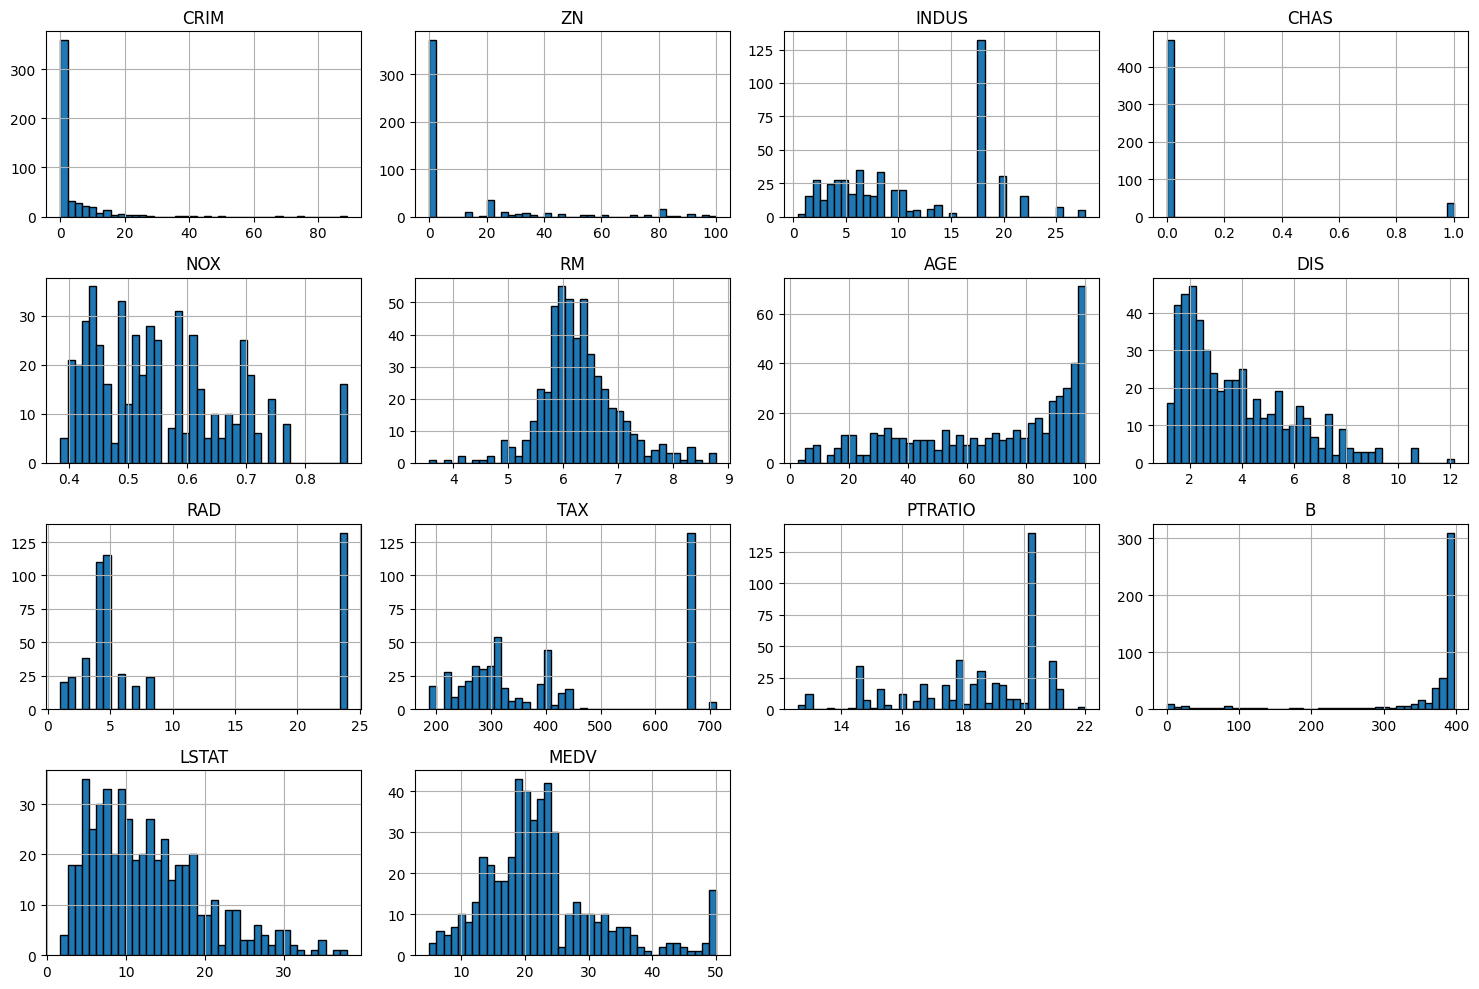

In [17]:
# Configuración del tamaño de las gráficas
housing_df.hist(bins=40, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

### Probamos categorizando ZN, RAD, TAX, NOX

#### Benchmark OLS

In [4]:
# Definir las features y el target
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Crear y entrenar el modelo OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Mostrar el resumen estadístico del modelo
print(ols_model.summary())

# Predecir valores en el conjunto de prueba
y_pred = ols_model.predict(X_test_sm)

# Usar la función para evaluar el modelo
print_regression_report(y_test, y_pred)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.43
Date:                Wed, 12 Feb 2025   Prob (F-statistic):          6.21e-109
Time:                        19:20:05   Log-Likelihood:                -1194.3
No. Observations:                 404   AIC:                             2417.
Df Residuals:                     390   BIC:                             2473.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2468      5.677      5.328      0.0

#### Categorización de variables

1. **`CHAS` (variable binaria)**:
   - Ya es una variable categórica. Asegurémonos de que se trate como una variable binaria en el modelo.

2. **`ZN` (proporción de terrenos residenciales)**:
   - Dado que la variable tiene una distribución sesgada, podemos probar dividirla en **categorías** (por ejemplo, bajo, medio y alto). Una opción sería usar percentiles para definir estas categorías.
   
3. **`TAX` (tasa de impuestos sobre propiedades)**:
   - Esta variable tiene un sesgo hacia valores altos. Podría beneficiarse de una transformación logarítmica o bien, agrupar valores similares en categorías.

4. **`AGE` (edad de las viviendas)**:
   - Similar a `TAX`, esta variable tiene una distribución sesgada y podría ser transformada o agrupada en categorías (por ejemplo, jóvenes, medias y viejas).

5. **`CRIM` (tasa de criminalidad)**:
   - Dado que también muestra un sesgo hacia valores bajos, podemos usar una transformación logarítmica o agrupar los valores en categorías (baja, media, alta criminalidad).


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Convertir CHAS a categórica (aunque ya es binaria, la dejamos como int)
housing_df['CHAS'] = housing_df['CHAS'].astype('category')

# Dividir ZN en dos categorías: 0 y >0
housing_df['ZN_cat'] = housing_df['ZN'].apply(lambda x: '0' if x == 0 else '>0')

# Log-transformar TAX
housing_df['TAX_log'] = np.log1p(housing_df['TAX'])

# Agrupar AGE en categorías
housing_df['AGE_cat'] = pd.cut(housing_df['AGE'], bins=[0, 50, 75, 100], labels=["joven", "media", "vieja"])

# Log-transformar CRIM
housing_df['CRIM_log'] = np.log1p(housing_df['CRIM'])

# Convertir las variables categóricas en variables dummy (One-Hot Encoding)
housing_df = pd.get_dummies(housing_df, columns=['CHAS', 'AGE_cat', 'ZN_cat'], drop_first=True)

# Convertir cualquier variable booleana a int (para asegurar que las categorías estén como enteros)
housing_df = housing_df.astype({col: 'int' for col in housing_df.select_dtypes('bool').columns})

# Definir las features y el target (ya sin las columnas originales)
X = housing_df.drop(['MEDV', 'ZN', 'TAX', 'AGE'], axis=1)  # Eliminar las variables originales
y = housing_df['MEDV']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agregar la constante para el término independiente (intercepto)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Crear y entrenar el modelo OLS
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Mostrar el resumen estadístico del modelo
print(ols_model.summary())

# Predecir valores en el conjunto de prueba
y_pred = ols_model.predict(X_test_sm)

# Evaluar el modelo con métricas
print_regression_report(y_test, y_pred)


                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     79.82
Date:                Wed, 12 Feb 2025   Prob (F-statistic):          1.90e-108
Time:                        19:20:08   Log-Likelihood:                -1190.8
No. Observations:                 404   AIC:                             2414.
Df Residuals:                     388   BIC:                             2478.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            50.0468      9.556      5.237